In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import io as skio, img_as_float

#Automatic Cropping: Bells and Whistle (is it?)
    #Idea
        #Allow for percent cropping -> %cropped on each side
            #Simple: It's an array -> subtract the %*h/w of the height and width
def percent_crop(img, pct=0.10):
    #get h,w 
    h, w = img.shape
    #find how much to remove (as int i think)
    dy,dx = int( h * pct), int(w*pct)
    #crop the img array
    return img[dy:h-dy, dx:w-dx]


In [3]:
#Image Pyramids
    #cv.resize by 2 with half resolution as well\
def build_pyr(img, min_size=400):
    p = [img.astype(np.float32)]
    #p -> gives list of pyramid imgs -> p[-1] to access the most recently added level
        #-> downsample to most recent img
    #keep going until min_size pixels are reached
    while min(p[-1].shape) > min_size:
        h,  w = p[-1].shape
        #down sample again
        resized = cv.resize(p[-1], (w//2, h//2), interpolation=cv.INTER_AREA)
        #cv.resize doesnt need additional blur -> given by the hiddne interpolation 
        p.append( resized)
    #return smallest to largest
    return p[::-1]

#BIG PROBLEM: WE CANT COUNT THE OVERLAP in the L2 CALCULATION - RUINS score
    #edges/misaligned boarders
def overlap(ref, mov, dy, dx, border=10):
    #basically move (dy, dx) by MOV # of times relative to REF
    H, W = ref.shape
    #change the rows/cols from ref so that they overlap with shifted mov
        #dy > 0 => move down
        #dy < 0 bottom shrings => H + dy
    y0r,y1r = max(0,dy),  min(H, H+dy)
    x0r,  x1r = max( 0,dx),  min(W, W+dx)

    #change the rows/cols from MOV!!!!
        #dy > 0 => move down
        #dy < 0 bottom shrings => H + dy
    y0m, y1m = max(0, -dy), min(H, H-dy)
    x0m, x1m = max(0, -dx), min( W, W-dx)

    #so now givbern the (dy, dx) we should be able to parse 2 patches (same0size) that overlap
    R = ref[y0r: y1r, x0r:x1r]
    M = mov[y0m :y1m, x0m : x1m]
    #R, M are now are 2 patches
    #EDGE CASES:
        #1. Overlap is empty / shapes don't match
    if R.size == 0 or M.size == 0 or R.shape != M.shape: return None, None
        #2. Patch is too small to trim a boarder (2*boarder)
    if R.shape[0] <= 2*border or R.shape[1] <= 2*border: return None, None

    #otherwise return the interrior (NON OVERLAP) of the two patches
    R_patch = R[border:-border, border:-border]
    M_patch = M[border:-border, border:-border]
    return R_patch, M_patch

In [4]:
#ALIGNMENT PROCESS: WITH L2 ONLY
    #Aligning ref to mov
    #1. Build a pyramid for both images
    #2. Guess the displacement vector to be (0, 0)
    #iterate over smallest pyramid pirain
    #find the best score via starting dummy shift
    #extract true-overlap (from helper funct) and then score (l2)
    #keep the best lowest score and then go back up pyramid scaling

def align_l2(ref, mov, min_size=300, win0=40, win=6, border=10):
    #build the pyramids
    Rp = build_pyr(ref, min_size)
    Mp = build_pyr(mov, min_size)
    dy = 0
    dx = 0

    #To iterate two different pyramids at tsame time 
        #zip but keep track of level => enumerate
    for lvl, (R, M) in enumerate(zip(Rp, Mp)):
        #deending on level, we want small shift for finer levels, vs large shifts for coardser (win0 vs win)
        if lvl == 0:
            w = win0 
        else:
            w = win


        #make the best super big since we want to mininmize L2
        best = (1e18, 0, 0)

        for yy in range(dy-w, dy+w+1):
            for xx in range(dx-w, dx+w+1):
                #we need to iterate over this patch +- w around the current (dy, dx)
                #find the overlap
                r, m = overlap(R, M, yy, xx)
                #EDGE CASE:
                    #1. Make sure the patch exists (double check given alr overlap func check)
                if r is None:
                    continue
                #SCORE: L2 (MSE)
                s = np.mean((r -  m) ** 2)
                #find best score (minimize)
                if s < best[0]:
                    best = (s, yy, xx)
        #move to the next finer level
            #remember we can just scale up by mulitplying by 2
        dy, dx = best[1]*2, best[2]*2
    #BRUH
    #can't return just dy, dx bc it will double on the last iteration => divide by 2 before returning
    return dy//2, dx//2

In [5]:
#now we need to stack the channels via the offset we found from alingment
#find one window (safe)
#ADD REF HERE 
    #figured out thta aligning to green first solves our brightness difference issue
def compose_with_ref(Ref, B, R, b_off, r_off):
    #get the (dy, dx) for B
    by, bx = b_off
    #get the (dy, dx) for R
    ry, rx = r_off

    H, W = Ref.shape
    #preprocess the ref image 
    #fiund the row range that ovelraps with the shifted B AND shifter R (to find one safe window)
    #y0 HAS to be > 0 and if B,R shiftens down (top also moves down) => take max
    y0 = max(max(0, by), max(0, ry))
    #via converse take min for bottom
    y1 = min(min(H, H+by), min(H, H+ry))

#same logic for columsn
    x0 = max(max(0, bx), max(0, rx))
    x1 = min(min(W, W+bx), min(W, W+rx))
#map the same window in each ref, b, and r image (since aligning to green)
    Rc = Ref[ y0:y1, x0: x1]
    Bc = B[y0- by: y1-by , x0-bx :x1-bx]
    Rc2 = R[y0-ry: y1-ry, x0-rx:x1-rx]
    return Rc, Bc, Rc2

B->G displacement (x,y): (-26, -54)
R->G displacement (x,y): (-7, 71)


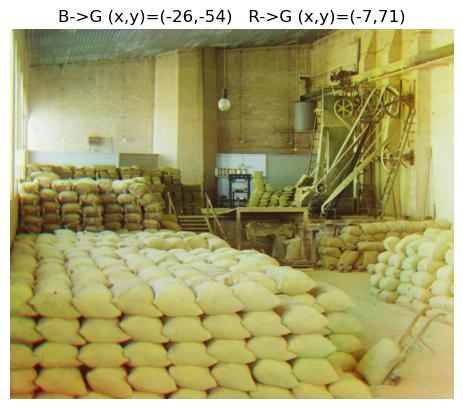

In [6]:
#just laod and crop (given skeleton)
im = img_as_float(skio.imread("data/random2.tif"))  # swap filename as needed
H = im.shape[0] // 3
B = percent_crop(im[0:H, :], 0.08)
G = percent_crop(im[H:2*H, :], 0.08)
R = percent_crop(im[2*H:3*H, :], 0.08)

#ALIGN TO GREEN HERE FOR EMIR
#WHICH MEAN B->G
#AND R-> G
b_dy, b_dx = align_l2(G, B)
r_dy, r_dx = align_l2(G, R)
print(f"B->G displacement (x,y): ({b_dx}, {b_dy})")
print(f"R->G displacement (x,y): ({r_dx}, {r_dy})")

#and then just show the image
Gf, Bf, Rf = compose_with_ref(G, B, R, (b_dy, b_dx), (r_dy, r_dx))
rgb = np.dstack([Rf, Gf, Bf])
plt.imshow(np.clip(rgb, 0, 1)); plt.axis('off')
plt.title(f"B->G (x,y)=({b_dx},{b_dy})   R->G (x,y)=({r_dx},{r_dy})")
plt.show()

In [7]:
#my old implementation using no pyramids but same scoring logic

def align_l2_single(ref, mov, win=15, border=8):
    best = (1e18, 0, 0)
    for dy in range(-win, win+1):
        for dx in range(-win, win+1):

            r,m = overlap(ref, mov, dy, dx, border)
            if r is None: 
                continue
            s =  np.mean((r - m)**2)
            if s< best[0]:
                best= (s,dy, dx)
    return best[1],best[2]

G->B displacement (x,y): (15, 15)
R->B displacement (x,y): (14, 15)


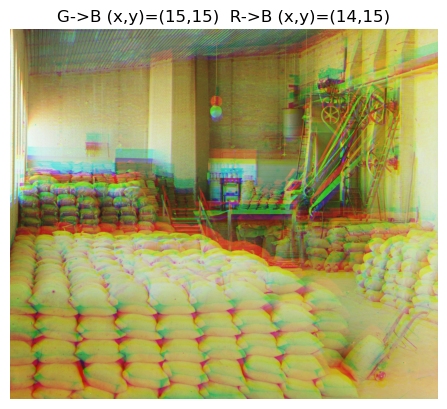

In [8]:
g_dy, g_dx = align_l2_single(B, G, win=15, border=8)
r_dy, r_dx = align_l2_single(B, R, win=15, border=8)
print(f"G->B displacement (x,y): ({g_dx}, {g_dy})")
print(f"R->B displacement (x,y): ({r_dx}, {r_dy})")

Bb, Gb, Rb = compose_with_ref(B, G, R, (g_dy, g_dx), (r_dy, r_dx))
rgb = np.dstack([Rb, Gb, Bb])
plt.imshow(np.clip(rgb, 0, 1)); plt.axis('off')
plt.title(f"G->B (x,y)=({g_dx},{g_dy})  R->B (x,y)=({r_dx},{r_dy})")
plt.show()